In [1]:
#!pip install -r requirements.txt

import os
os.environ['PATH'] += os.pathsep + '/home/jovyan/.local/bin'

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import awkward as ak
from statistics import median
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import random
import json
import time
import sys

# Load data

In [3]:
import s3fs

s3 = s3fs.core.S3FileSystem(anon=True, client_kwargs={'endpoint_url': 'https://s3.cern.ch'})

In [4]:
flist = s3.glob('s3://jec-data/open/katib/test/*.root')

In [5]:
flist

['jec-data/open/katib/test/JetNtuple_RunIISummer16_13TeV_MC_103.root',
 'jec-data/open/katib/test/JetNtuple_RunIISummer16_13TeV_MC_96.root']

In [6]:
from utils.config import DataConfig
from utils.fileio import read_files
from utils.preprocess import build_new_variables, finalize_inputs

def get_data(data_config_file):
    data_config = DataConfig.load(data_config_file)
    table = read_files(flist, data_config.load_branches, s3)
    # define new variables
    build_new_variables(table, data_config.var_funcs)
    # perform input variable standardization, clipping, padding and stacking
    finalize_inputs(table, data_config)
    
    input_data = {key: table[f'_{key}'] for key in data_config.inputs.keys()}
    
    observers = ak.to_dataframe({k: table[k] for k in data_config.observers})
    
    return input_data, observers

In [7]:
pfn_input_data, observers = get_data('https://raw.githubusercontent.com/deinal/weaver/dev/jet-energy-corrections/data/jec_pfn_open.yaml')
for key in pfn_input_data:
    print(key, pfn_input_data[key].shape)

/home/jovyan/.local/lib/python3.8/site-packages/awkward/_backends.py:58: RuntimeWarning: divide by zero encountered in log
  return getattr(ufunc, method)(*args, **kwargs)


pf_features (286645, 6, 100)
pf_mask (286645, 1, 100)
jet_features (286645, 8)


In [8]:
particlenet_input_data, _ = get_data('https://raw.githubusercontent.com/deinal/weaver/dev/jet-energy-corrections/data/jec_particle_net_open.yaml')
for key in particlenet_input_data:
    print(key, particlenet_input_data[key].shape)

/home/jovyan/.local/lib/python3.8/site-packages/awkward/_backends.py:58: RuntimeWarning: divide by zero encountered in log
  return getattr(ufunc, method)(*args, **kwargs)


pf_points (286645, 2, 100)
pf_features (286645, 6, 100)
pf_mask (286645, 1, 100)
jet_features (286645, 8)


In [9]:
observers.head()

jetPt    genJetPt  genJetEta  partonFlav  hadronFlav
entry                                                           
0       57.387169   59.624565  -2.215691        21.0         0.0
1       34.731983   48.733902  -1.511485         4.0         4.0
2      334.307159  315.566498  -1.439479        21.0         0.0
3      215.078369  290.740326  -1.383814         3.0         0.0
4       53.059177   54.193817  -0.552095        21.0         0.0

In [10]:
data_len = observers.shape[0]

In [11]:
df = observers.copy()
df.columns = ['pt', 'pt_gen', 'eta_gen', 'parton_flavor', 'hadron_flavor']
df['flavour'] = df.hadron_flavor.where(df.hadron_flavor != 0, other=np.abs(df.parton_flavor))
df = df.drop(columns=['parton_flavor', 'hadron_flavor'])
df.head()

pt      pt_gen   eta_gen  flavour
entry                                           
0       57.387169   59.624565 -2.215691     21.0
1       34.731983   48.733902 -1.511485      4.0
2      334.307159  315.566498 -1.439479     21.0
3      215.078369  290.740326 -1.383814      3.0
4       53.059177   54.193817 -0.552095     21.0

In [12]:
def loss(y_pred, y_true):
    mask = np.logical_and(y_true > -1, y_true < 1)
    return np.mean(np.abs(y_pred - y_true) * mask)

In [13]:
target = np.log(observers.genJetPt / observers.jetPt)
baseline = np.log(observers.jetPt / observers.jetPt)

loss(baseline, target)

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.09427206371952135

# Triton inference

### Set up client

In [14]:
import tritonclient.http as httpclient

In [15]:
pfn_triton_client_cpu = httpclient.InferenceServerClient(url='pfn-regressor-open-de181d.dholmber.svc.cluster.local', verbose=False)
particlenet_triton_client_cpu = httpclient.InferenceServerClient(url='particle-net-regressor-open-793295.dholmber.svc.cluster.local', verbose=False)

In [16]:
pfn_triton_client_gpu = httpclient.InferenceServerClient(url='pfn-regressor-open-gpu.dholmber.svc.cluster.local', verbose=False)
particlenet_triton_client_gpu = httpclient.InferenceServerClient(url='particle-net-regressor-open-gpu.dholmber.svc.cluster.local', verbose=False)

In [17]:
pfn_triton_client_cpu_basic = httpclient.InferenceServerClient(url='pfn-regressor-open-de181d-basic.dholmber.svc.cluster.local', verbose=False)
pfn_triton_client_gpu_basic = httpclient.InferenceServerClient(url='pfn-regressor-open-gpu-basic.dholmber.svc.cluster.local', verbose=False)

In [18]:
def infer(triton_client, inputs):
    triton_inputs = []
    for i, key in enumerate(inputs.keys()):
        triton_inputs.append(httpclient.InferInput(name=key, shape=inputs[key].shape, datatype='FP32'))
        triton_inputs[i].set_data_from_numpy(inputs[key])

    triton_outputs = [httpclient.InferRequestedOutput(name='output')]

    results = triton_client.infer(
        model_name='optimal',
        inputs=triton_inputs,
        outputs=triton_outputs
    )
    return results

In [19]:
# !curl http://pfn-regressor-open-gpu.dholmber.svc.cluster.local/v2/models/optimal/stats

### Initialize inference experiment parameters

In [20]:
num_repeats = 1000
batch_sizes = [int(i) for i in np.logspace(start=1, stop=10, num=10, base=2)]

### Gather statistics

In [21]:
def gather_statistics(triton_client, input_data, num_repeats, batch_sizes):
    batch_stats = {batch_size: {'input_time': [], 'inference_time': [], 'output_time': [], 'roundtrip_time': [], 'inference_count': 0, 'total_inference_time': 0} for batch_size in batch_sizes}
    
    statistics = triton_client.get_inference_statistics(model_name='optimal')
    initial_batch_stats = statistics['model_stats'][0]['batch_stats']

    for initial_stat in initial_batch_stats:
        batch_size = initial_stat['batch_size']
        if batch_size in batch_sizes:
            initial_inference = initial_stat['compute_infer']
            batch_stats[batch_size]['total_inference_time'] = initial_inference['ns']
    
    for batch_size in tqdm(batch_sizes):
        while batch_stats[batch_size]['inference_count'] < num_repeats:
            indices = random.sample(range(data_len), batch_size)
            inputs = {}
            for key in input_data:
                inputs[key] = input_data[key][indices]
            
            start = time.perf_counter_ns()
            results = infer(triton_client, inputs)
            end = time.perf_counter_ns()
            time_diff = end - start

            statistics = triton_client.get_inference_statistics(model_name='optimal')
            all_current_batch_stats = statistics['model_stats'][0]['batch_stats']
            for stat in all_current_batch_stats:
                if stat['batch_size'] == batch_size:
                    current_batch = stat
                    break
            
            last_inference_time = current_batch['compute_infer']['ns'] - batch_stats[batch_size]['total_inference_time']
            
            batch_stats[batch_size]['inference_time'].append(last_inference_time)
            batch_stats[batch_size]['roundtrip_time'].append(time_diff)
            batch_stats[batch_size]['total_inference_time'] = current_batch['compute_infer']['ns']
            batch_stats[batch_size]['inference_count'] += 1
    
    return batch_stats

In [22]:
gather_statistics(pfn_triton_client_cpu, pfn_input_data, 10, [16]) # warmup
pfn_stats_cpu = gather_statistics(pfn_triton_client_cpu, pfn_input_data, num_repeats, batch_sizes)

100%|██████████| 10/10 [08:00<00:00, 48.07s/it]


In [55]:
gather_statistics(particlenet_triton_client_cpu, particlenet_input_data, 10, [16])
particle_net_stats_cpu = gather_statistics(particlenet_triton_client_cpu, particlenet_input_data, num_repeats, batch_sizes)

100%|██████████| 10/10 [5:03:08<00:00, 1818.84s/it]


In [56]:
gather_statistics(pfn_triton_client_gpu, pfn_input_data, 10, [16])
pfn_stats_gpu = gather_statistics(pfn_triton_client_gpu, pfn_input_data, num_repeats, batch_sizes)

100%|██████████| 10/10 [02:20<00:00, 14.07s/it]


In [57]:
gather_statistics(particlenet_triton_client_gpu, particlenet_input_data, 10, [16])
particle_net_stats_gpu = gather_statistics(particlenet_triton_client_gpu, particlenet_input_data, num_repeats, batch_sizes)

100%|██████████| 10/10 [19:47<00:00, 118.70s/it]


In [107]:
gather_statistics(pfn_triton_client_cpu_basic, pfn_input_data, 10, [16])
pfn_stats_cpu_basic_new = gather_statistics(pfn_triton_client_cpu_basic, pfn_input_data, num_repeats, batch_sizes)

100%|██████████| 10/10 [25:03<00:00, 150.34s/it]


In [108]:
gather_statistics(pfn_triton_client_gpu_basic, pfn_input_data, 10, [16])
pfn_stats_gpu_basic = gather_statistics(pfn_triton_client_gpu_basic, pfn_input_data, num_repeats, batch_sizes)

100%|██████████| 10/10 [02:30<00:00, 15.08s/it]


### Calculate metrics

In [93]:
def calculate_time(batch_stats, batch_sizes):
    roundtrips = []
    inferences = []
    overheads = []

    for batch_size in batch_sizes:
        count = batch_stats[batch_size]['inference_count']
        if not count:
            continue
        
        roundtrip_us = np.array(batch_stats[batch_size]['roundtrip_time']) / 1e3
        inference_us = np.array(batch_stats[batch_size]['inference_time']) / 1e3
        
        roundtrip_per_jet = np.mean(roundtrip_us) / batch_size
        inference_per_jet = np.mean(inference_us) / batch_size
        overhead_per_jet = np.mean(roundtrip_us - inference_us) / batch_size
        
        roundtrips.append(roundtrip_per_jet)
        inferences.append(inference_per_jet)
        overheads.append(overhead_per_jet)
    
    return roundtrips, inferences, overheads

In [94]:
pfn_roundtrip_cpu, pfn_inference_cpu, pfn_overhead_cpu = calculate_time(pfn_stats_cpu, batch_sizes)
pfn_roundtrip_gpu, pfn_inference_gpu, pfn_overhead_gpu = calculate_time(pfn_stats_gpu, batch_sizes)
pfn_roundtrip_cpu_basic, pfn_inference_cpu_basic, pfn_overhead_cpu_basic = calculate_time(pfn_stats_cpu_basic, batch_sizes)
pfn_roundtrip_gpu_basic, pfn_inference_gpu_basic, pfn_overhead_gpu_basic = calculate_time(pfn_stats_gpu_basic, batch_sizes)
particlenet_roundtrip_cpu, particlenet_inference_cpu, particlenet_overhead_cpu = calculate_time(particle_net_stats_cpu, batch_sizes)
particlenet_roundtrip_gpu, particlenet_inference_gpu, particlenet_overhead_gpu = calculate_time(particle_net_stats_gpu, batch_sizes)

In [95]:
def plot_times(
        path,
        ylabel,
        pfn_cpu_basic, pfn_cpu, particlenet_cpu,
        pfn_gpu_basic, pfn_gpu, particlenet_gpu,
        loc='upper left'
    ):
    fig = plt.figure(figsize=(6, 4.8), facecolor='white')
    ax = fig.add_subplot()
    ax.scatter(batch_sizes, pfn_gpu_basic, label='PFN (GPU)', marker='v', s=20)
    ax.scatter(batch_sizes, pfn_gpu, label='PFN Opt. (GPU)', marker='^', s=20)
    ax.scatter(batch_sizes, particlenet_gpu, label='ParticleNet (GPU)', marker='x', s=20, linewidths=2)
    ax.scatter(batch_sizes, pfn_cpu_basic, label='PFN (CPU)', marker='o', s=20)
    ax.scatter(batch_sizes, pfn_cpu, label='PFN Opt. (CPU)', marker='s', s=20)
    ax.scatter(batch_sizes, particlenet_cpu, label='ParticleNet (CPU)', marker='D', s=20)
    ax.set_xlabel('Batch size', fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_xscale('log', base=2)
    ax.set_xticks(batch_sizes)
    ax.set_yscale('log')
    plt.legend(loc=loc, prop={'size': 11})
    plt.tight_layout()
    ax.tick_params(
        axis='both', which='both', direction='in', width=1.2,
        bottom=True, top=True, left=True, right=True, labelsize=13
    )
    for ext in ['png', 'pdf', 'svg', 'eps']:
        plt.savefig(f'{path}.{ext}')
    plt.show()

### Plot inference time

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


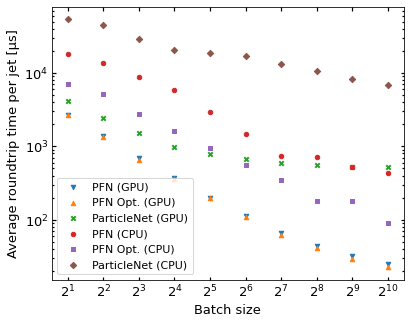

In [96]:
plot_times(
    'figs/time/roundtrip',
    'Average roundtrip time per jet [μs]', 
    pfn_roundtrip_cpu_basic, pfn_roundtrip_cpu, particlenet_roundtrip_cpu,
    pfn_roundtrip_gpu_basic, pfn_roundtrip_gpu, particlenet_roundtrip_gpu,
    loc='lower left'
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


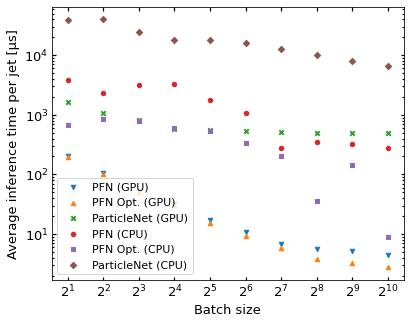

In [97]:
plot_times(
    'figs/time/inference',
    'Average inference time per jet [μs]', 
    pfn_inference_cpu_basic, pfn_inference_cpu, particlenet_inference_cpu,
    pfn_inference_gpu_basic, pfn_inference_gpu, particlenet_inference_gpu,
    loc='lower left'
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


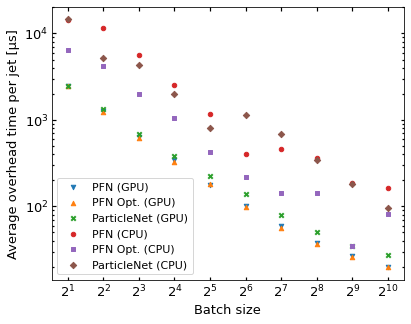

In [98]:
plot_times(
    'figs/time/overhead',
    'Average overhead time per jet [μs]', 
    pfn_overhead_cpu_basic, pfn_overhead_cpu, particlenet_overhead_cpu,
    pfn_overhead_gpu_basic, pfn_overhead_gpu, particlenet_overhead_gpu,
    loc='lower left'
)

In [99]:
def plot_times_subplot(
        path,
        titles,
        pfn_cpu_basic, pfn_cpu, particlenet_cpu,
        pfn_gpu_basic, pfn_gpu, particlenet_gpu,
        loc
    ):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), facecolor='white')

    for i in range(3):
        ax = axes[i]
        l1 = ax.scatter(batch_sizes, pfn_gpu_basic[i], label='PFN (GPU)', marker='v', s=20)
        l2 = ax.scatter(batch_sizes, pfn_gpu[i], label='PFN Opt. (GPU)', marker='^', s=20)
        l3 = ax.scatter(batch_sizes, particlenet_gpu[i], label='ParticleNet (GPU)', marker='x', s=20, linewidths=2)
        l4 = ax.scatter(batch_sizes, pfn_cpu_basic[i], label='PFN (CPU)', marker='o', s=20)
        l5 = ax.scatter(batch_sizes, pfn_cpu[i], label='PFN Opt. (CPU)', marker='s', s=20)
        l6 = ax.scatter(batch_sizes, particlenet_cpu[i], label='ParticleNet (CPU)', marker='D', s=20)
        ax.set_xlabel('Batch size', fontsize=14)
        if i == 1:
            ax.set_ylim([1.7, 4e5])
        else:
            ax.set_ylim([1.7, 4e5])
        ax.set_ylabel(f'{titles[i]} time per jet [μs]', fontsize=14)
        ax.set_xscale('log', base=2)
        ax.set_xticks(batch_sizes)
        ax.set_yscale('log')
        leg1 = ax.legend(handles=[l4, l5, l6], loc='lower left', bbox_to_anchor=(-0.03, -0.01), frameon=False, handletextpad=0.2, labelspacing=0.33,columnspacing=0.3, prop={'size': 12})
        ax.add_artist(leg1)
        ax.legend(handles=[l1, l2, l3], loc='upper right', bbox_to_anchor=(1.01, 1.005), frameon=False, handletextpad=0.2, labelspacing=0.33, columnspacing=0.3, prop={'size': 12})
        ax.tick_params(
            axis='both', which='both', direction='in', width=1.2,
            bottom=True, top=True, left=True, right=True, labelsize=14
        )
    fig.tight_layout(pad=2)
    for ext in ['png', 'pdf', 'svg', 'eps']:
        plt.savefig(f'{path}.{ext}')
    plt.show()

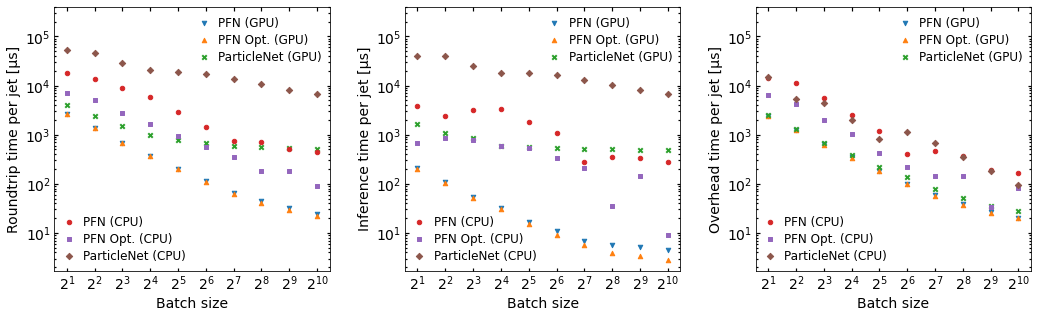

In [100]:
plot_times_subplot(
    'figs/time/merged',
    ['Roundtrip', 'Inference', 'Overhead'],
    [pfn_roundtrip_cpu_basic, pfn_inference_cpu_basic, pfn_overhead_cpu_basic],
    [pfn_roundtrip_cpu, pfn_inference_cpu, pfn_overhead_cpu],
    [particlenet_roundtrip_cpu, particlenet_inference_cpu, particlenet_overhead_cpu],
    [pfn_roundtrip_gpu_basic, pfn_inference_gpu_basic, pfn_overhead_gpu_basic],
    [pfn_roundtrip_gpu, pfn_inference_gpu, pfn_overhead_gpu],
    [particlenet_roundtrip_gpu, particlenet_inference_gpu, particlenet_overhead_gpu],
    loc='lower left'
)

In [101]:
data = {
    'batch_sizes': batch_sizes,
    'pfn_cpu_roundtrip': list(pfn_roundtrip_cpu),
    'pfn_cpu_inference': list(pfn_inference_cpu),
    'pfn_cpu_overhead': list(pfn_overhead_cpu),
    'pfn_gpu_roundtrip': list(pfn_roundtrip_gpu),
    'pfn_gpu_inference': list(pfn_inference_gpu),
    'pfn_gpu_overhead': list(pfn_overhead_gpu),
    'pfn_cpu_basic_roundtrip': list(pfn_roundtrip_cpu_basic),
    'pfn_cpu_basic_inference': list(pfn_inference_cpu_basic),
    'pfn_cpu_basic_overhead': list(pfn_overhead_cpu_basic),
    'pfn_gpu_basic_roundtrip': list(pfn_roundtrip_gpu_basic),
    'pfn_gpu_basic_inference': list(pfn_inference_gpu_basic),
    'pfn_gpu_basic_overhead': list(pfn_overhead_gpu_basic),
    'particlenet_cpu_roundtrip': list(particlenet_roundtrip_cpu),
    'particlenet_cpu_inference': list(particlenet_inference_cpu),
    'particlenet_cpu_overhead': list(particlenet_overhead_cpu),
    'particlenet_gpu_roundtrip': list(particlenet_roundtrip_gpu),
    'particlenet_gpu_inference': list(particlenet_inference_gpu),
    'particlenet_gpu_overhead': list(particlenet_overhead_gpu),
}

with open('figs/time/data.json', 'w') as f:
    json.dump(data, f, indent='\t')

### Plot inference throughput

In [102]:
def calculate_throughput(batch_stats, batch_sizes):
    roundtrip = []
    inference = []
    for batch_size in batch_sizes:
        count = batch_stats[batch_size]['inference_count']
        if not count:
            continue
        
        r = batch_size * count / sum(batch_stats[batch_size]['roundtrip_time']) * 1e9
        i = batch_size * count / sum(batch_stats[batch_size]['inference_time']) * 1e9
        
        roundtrip.append(r)
        inference.append(i)
    
    return roundtrip, inference

In [103]:
pfn_roundtrip_cpu, pfn_inference_cpu = calculate_throughput(pfn_stats_cpu, batch_sizes)
pfn_roundtrip_gpu, pfn_inference_gpu = calculate_throughput(pfn_stats_gpu, batch_sizes)
pfn_roundtrip_cpu_basic, pfn_inference_cpu_basic = calculate_throughput(pfn_stats_cpu_basic, batch_sizes)
pfn_roundtrip_gpu_basic, pfn_inference_gpu_basic = calculate_throughput(pfn_stats_gpu_basic, batch_sizes)
particlenet_roundtrip_cpu, particlenet_inference_cpu = calculate_throughput(particle_net_stats_cpu, batch_sizes)
particlenet_roundtrip_gpu, particlenet_inference_gpu = calculate_throughput(particle_net_stats_gpu, batch_sizes)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


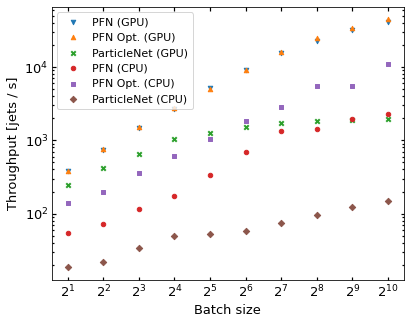

In [104]:
plot_times(
    'figs/throughput/roundtrip',
    'Throughput [jets / s]', 
    pfn_roundtrip_cpu_basic, pfn_roundtrip_cpu, particlenet_roundtrip_cpu,
    pfn_roundtrip_gpu_basic, pfn_roundtrip_gpu, particlenet_roundtrip_gpu
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


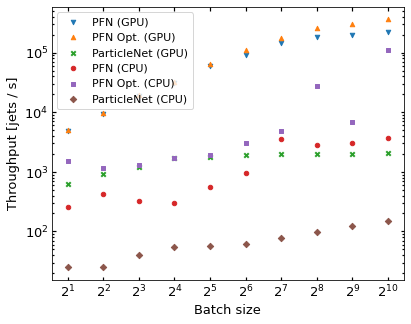

In [105]:
plot_times(
    'figs/throughput/inference',
    'Throughput [jets / s]', 
    pfn_inference_cpu_basic, pfn_inference_cpu, particlenet_inference_cpu,
    pfn_inference_gpu_basic, pfn_inference_gpu, particlenet_inference_gpu
)

In [106]:
data = {
    'batch_sizes': batch_sizes,
    'pfn_cpu_roundtrip': list(pfn_roundtrip_cpu),
    'pfn_cpu_inference': list(pfn_inference_cpu),
    'pfn_gpu_roundtrip': list(pfn_roundtrip_gpu),
    'pfn_gpu_inference': list(pfn_inference_gpu),
    'pfn_cpu_basic_roundtrip': list(pfn_roundtrip_cpu_basic),
    'pfn_cpu_basic_inference': list(pfn_inference_cpu_basic),
    'pfn_gpu_basic_roundtrip': list(pfn_roundtrip_gpu_basic),
    'pfn_gpu_basic_inference': list(pfn_inference_gpu_basic),
    'particlenet_cpu_roundtrip': list(particlenet_roundtrip_cpu),
    'particlenet_cpu_inference': list(particlenet_inference_cpu),
    'particlenet_gpu_roundtrip': list(particlenet_roundtrip_gpu),
    'particlenet_gpu_inference': list(particlenet_inference_gpu),
}

with open('figs/throughput/data.json', 'w') as f:
    json.dump(data, f, indent='\t')

# Physics results

In [74]:
batch_size = 100

In [75]:
def get_predictions(triton_client, input_data, batch_size):
    predictions = []

    for i in tqdm(range(0, data_len, batch_size)):
        inputs = {}
        for key in input_data:
            inputs[key] = input_data[key][i:i+batch_size]

        results = infer(triton_client, inputs)

        predictions.append(results.as_numpy(name='output'))

    return np.concatenate(predictions)

In [76]:
pfn_predictions = get_predictions(pfn_triton_client_gpu, pfn_input_data, batch_size)

100%|██████████| 2867/2867 [00:22<00:00, 126.02it/s]


In [77]:
particlenet_predictions = get_predictions(particlenet_triton_client_gpu, particlenet_input_data, batch_size)

100%|██████████| 2867/2867 [02:58<00:00, 16.09it/s]


In [78]:
outdir = 'figs'
network_names = ['PFN', 'ParticleNet']
names = ['Baseline'] + network_names
preds = {'PFN': pfn_predictions.squeeze(), 'ParticleNet': particlenet_predictions.squeeze()}

In [79]:
df['Baseline'] = df.pt / df.pt_gen
for name in network_names:
    corrected_pt = np.exp(preds[name]) * df.pt
    df[name] = corrected_pt / df.pt_gen

binning = np.geomspace(20, 3000, 20)
bin_centers = np.sqrt(binning[:-1] * binning[1:])

In [80]:
os.makedirs(outdir, exist_ok=True)

for subdir in ['distributions', 'flavours', 'response', 'resolution', 'residual']:
    for ext in ['png', 'pdf', 'svg']:
        os.makedirs(os.path.join(outdir, subdir, ext), exist_ok=True)

In [81]:
#del sys.modules[compare_flavours.__module__]
#del sys.modules[plot_resolution.__module__]
#del sys.modules[plot_median_response.__module__]
#del sys.modules[compute_resolution_improvement.__module__]
#del sys.modules[to_serializable.__module__]
#del sys.modules[plot_distrs.__module__]
#del sys.modules[plot_median_residual.__module__]

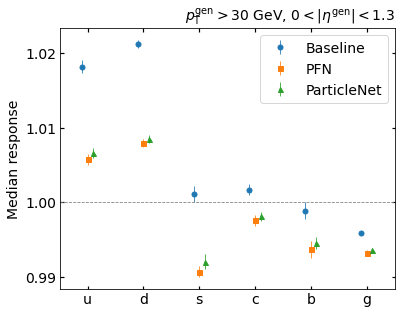

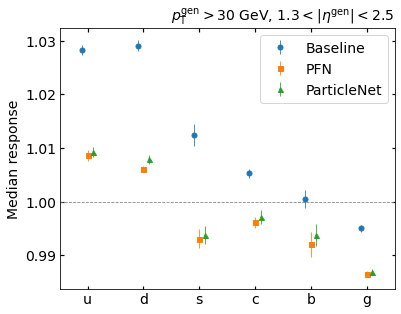

In [82]:
%%capture --no-display
from utils.plot import compare_flavours

compare_flavours(df, names, os.path.join(outdir, 'flavours'))

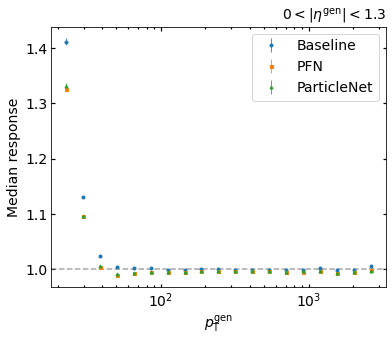

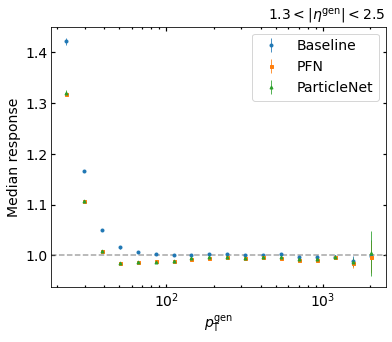

In [83]:
from utils.plot import plot_median_response

for (ieta, eta_bin), (flavour_label, flavour_ids) in itertools.product(
    enumerate([(0, 1.3), (1.3, 2.5)], start=1),
    [
        ('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21}),
        ('all', {0, 1, 2, 3, 4, 5, 21})
    ]
):
    df_bin = df[
        (np.abs(df.eta_gen) >= eta_bin[0])
        & (np.abs(df.eta_gen) < eta_bin[1])
        & df.flavour.isin(flavour_ids)
    ]
    bins = df_bin.groupby(pd.cut(df_bin.pt_gen, binning))

    plot_median_response(
        os.path.join(outdir, 'response'),
        flavour_label, bins, bin_centers, eta_bin, ieta, names
    )

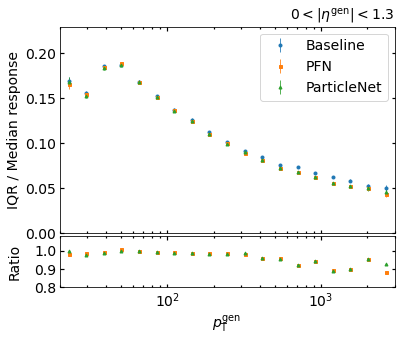

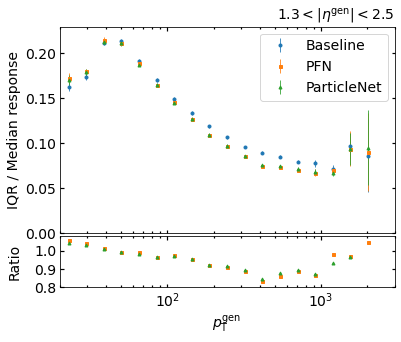

In [84]:
from utils.plot import plot_resolution, compute_resolution_improvement, to_serializable

data = {}
for (ieta, eta_bin), (flavour_label, flavour_ids) in itertools.product(
    enumerate([(0, 1.3), (1.3, 2.5)], start=1),
    [
        ('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21}),
        ('all', {0, 1, 2, 3, 4, 5, 21})
    ]
):
    df_bin = df[
        (np.abs(df.eta_gen) >= eta_bin[0])
        & (np.abs(df.eta_gen) < eta_bin[1])
        & df.flavour.isin(flavour_ids)
    ]
    bins = df_bin.groupby(pd.cut(df_bin.pt_gen, binning))

    data[f'{flavour_label}_eta{ieta}'] = plot_resolution(
        os.path.join(outdir, 'resolution'),
        flavour_label, bins, bin_centers, eta_bin, ieta, binning, names
    )

    for (ipt, pt_bin) in enumerate(
            [(30, np.inf), (30, 100), (100, 300), (300, 1000), (1000, np.inf)], start=1
        ):
        pt_bin = df_bin[
            (df_bin.pt_gen >= pt_bin[0])
            & (df_bin.pt_gen < pt_bin[1])
        ]
        data[f'{flavour_label}_eta{ieta}']['improvement'][f'pt{ipt}'] = compute_resolution_improvement(pt_bin, names)

with open(os.path.join(outdir, 'resolution', 'data.json'), 'w') as f:
    json.dump(data, f, indent='\t', default=to_serializable)

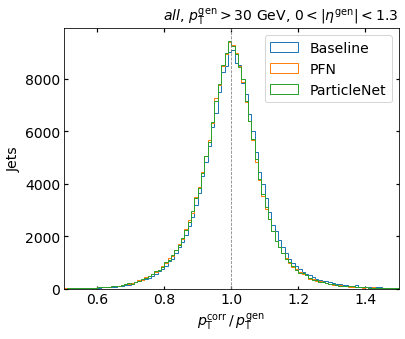

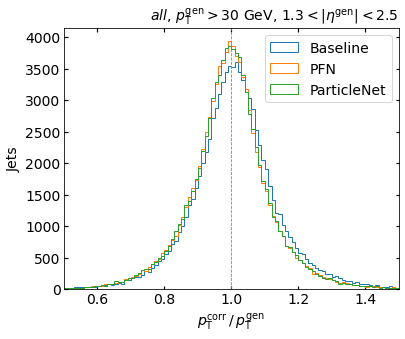

In [85]:
from utils.plot import plot_distrs

plot_distrs(df, names, os.path.join(outdir, 'distributions'))

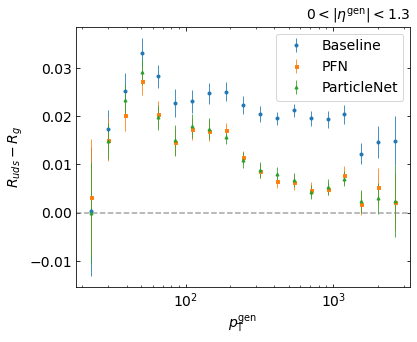

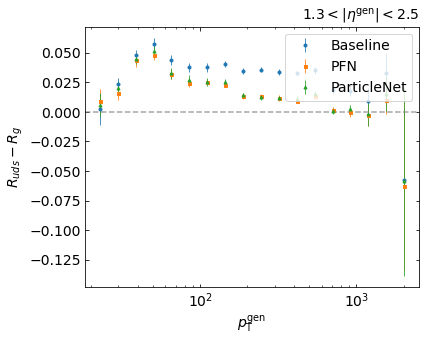

In [86]:
from utils.plot import plot_median_residual

for (ieta, eta_bin), flavours in itertools.product(
    enumerate([(0, 1.3), (1.3, 2.5)], start=1),
    itertools.combinations([('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21})], r=2),
):
    bins = []
    for i, flavour_ids in enumerate([flavours[0][1], flavours[1][1]]):
        df_bin = df[
            (np.abs(df.eta_gen) >= eta_bin[0])
            & (np.abs(df.eta_gen) < eta_bin[1])
            & df.flavour.isin(flavour_ids)
        ]
        bins.append(df_bin.groupby(pd.cut(df_bin.pt_gen, binning)))

    plot_median_residual(
        os.path.join(outdir, 'residual'),
        bin_centers, (flavours[0][0], flavours[1][0]), bins, eta_bin, ieta, names
    )